In [2]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [4]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


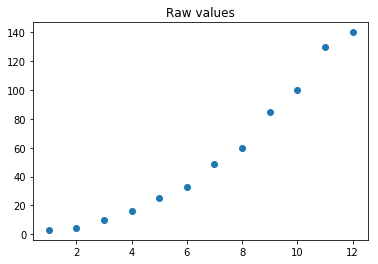

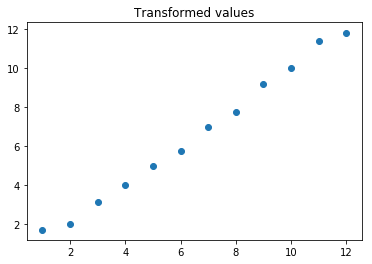

In [5]:
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

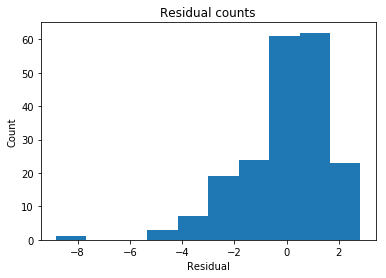

In [6]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

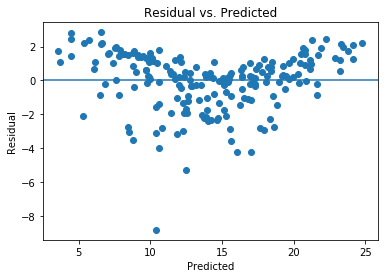

In [7]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

In [8]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


## Drill: fixing assumptions

Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality.  Use the cell(s) below to see what you can do to fix it.

### Multivariate non-normality

In [10]:
data['residual'] = data['Sales'] - regr.predict(X).ravel()
data['residual'].describe()

count   200.000
mean      0.000
std       1.673
min      -8.828
25%      -0.891
50%       0.242
75%       1.189
max       2.829
Name: residual, dtype: float64

In [16]:
#data with residuals below the 25th quantile
outliers = data.loc[data['residual'] < -0.891]
print(outliers)

     Unnamed: 0      TV  Radio  Newspaper  Sales  residual
1             2  44.500 39.300     45.100 10.400    -1.938
2             3  17.200 45.900     69.300  9.300    -3.008
5             6   8.700 48.900     75.000  7.200    -5.278
9            10 199.800  2.600     21.200 10.600    -1.951
12           13  23.800 35.100     65.900  9.200    -1.377
21           22 237.400  5.100     23.500 12.500    -2.241
23           24 228.300 16.900     26.200 15.500    -1.046
25           26 262.900  3.500     19.500 12.000    -3.610
27           28 240.100 16.700     22.900 15.900    -1.152
33           34 265.600 20.000      0.300 17.400    -1.464
35           36 290.700  4.100      8.500 12.800    -4.207
37           38  74.700 49.400     45.700 14.700    -0.923
42           43 293.600 27.700      1.800 20.700    -0.896
43           44 206.900  8.400     26.400 12.900    -1.064
48           49 227.200 15.800     49.900 14.800    -1.464
50           51 199.800  3.100     34.600 11.400    -1.2

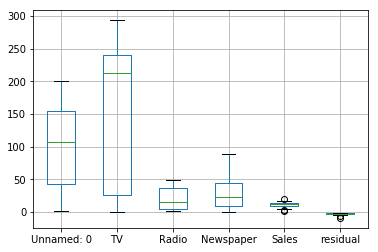

In [17]:
outliers.boxplot()

In [18]:
data['tv_log'] = np.log(data['TV'])

In [19]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper', 'tv_log']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.02258567  0.19817726 -0.00232637  2.22204041]]

Intercept: 
 [-4.21935622]

R-squared:
0.9353129406771284


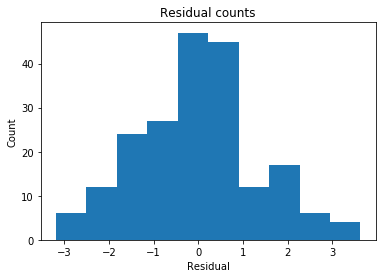

In [20]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Residual distribution is closer to normal using new feature of TV log.

### Heteroscedasticity

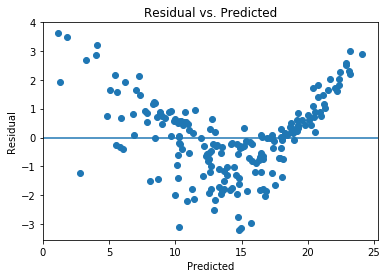

In [21]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Improving the multivariate non-normality with a log of TV has already improved the heteroscedasticity, so let's look at the other variables.  Radio and Newspaper show the least correlation, so let's put emphasis on them by creating a new feature by taking the square of each.

In [32]:
data['sq_radio'] = data['Radio'] * data['Radio']

In [36]:
data['sq_newspaper'] = data['Newspaper'] * data['Newspaper']

In [37]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper', 'tv_log', 'sq_radio', 'sq_newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.27641922e-02  1.66699958e-01  5.45699439e-03  2.20690317e+00
   6.66923086e-04 -1.03731232e-04]]

Intercept: 
 [-4.04183865]

R-squared:
0.9360589532924426


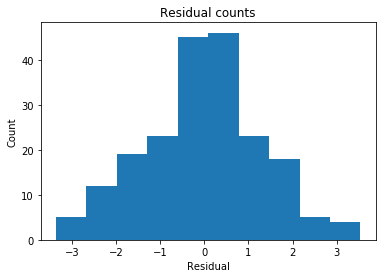

In [38]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

The distribution of the residual is even more normal with these new features.

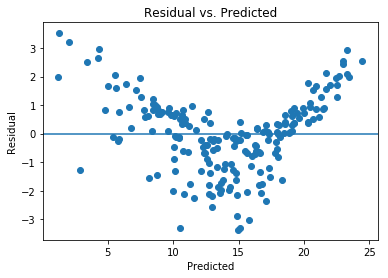

In [39]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

We see a small improvement on heteroscedasticity with these new features.